In [10]:
%pip install qiskit
%pip install qiskit[visualization]

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


Theoretical Bloch vector result: [0.9428090415820635, 0, 0.3333333333333333]
Resulting Bloch vector: [0.939453125, 0.00146484375, 0.319580078125]


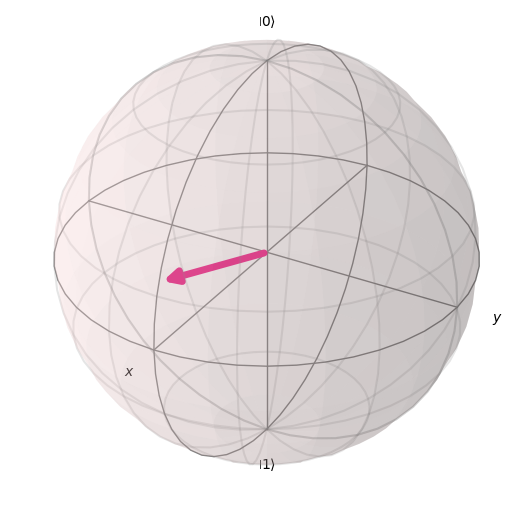

In [24]:
from math import sqrt
from qiskit import QuantumCircuit
from qiskit.primitives import StatevectorSampler
from qiskit.visualization import plot_bloch_vector


def quantum_state_tomography(alpha, beta):
    qc: QuantumCircuit = QuantumCircuit(1, 1)
    target_state_vector = [alpha, beta]
    qc.initialize(target_state_vector, 0)

    measure_x = QuantumCircuit(1, 1)
    measure_x.h(0)
    measure_x.measure(0, 0)

    measure_y = QuantumCircuit(1, 1)
    measure_y.sdg(0)
    measure_y.h(0)
    measure_y.measure(0, 0)

    measure_z = QuantumCircuit(1, 1)
    measure_z.measure(0, 0)

    qc_x = qc.compose(measure_x)
    qc_y = qc.compose(measure_y)
    qc_z = qc.compose(measure_z)

    state_vector_sampler = StatevectorSampler()
    shots = 8192
    results_x = state_vector_sampler.run([qc_x], shots=shots).result()
    results_y = state_vector_sampler.run([qc_y], shots=shots).result()
    results_z = state_vector_sampler.run([qc_z], shots=shots).result()

    counts_x = results_x[0].data.c.get_counts()
    counts_y = results_y[0].data.c.get_counts()
    counts_z = results_z[0].data.c.get_counts()

    x = abs(counts_x.get('0', 0) - counts_x.get('1', 0)) / shots
    y = abs(counts_y.get('0', 0) - counts_y.get('1', 0)) / shots
    z = abs(counts_z.get('0', 0) - counts_z.get('1', 0)) / shots

    return [x, y, z]

alpha = sqrt(2 / 3)
beta = sqrt(1 / 3)
bloch_vector = quantum_state_tomography(alpha, beta)
print("Theoretical Bloch vector result:", [(2 * sqrt(2)) / 3, 0, 1 / 3])
print("Resulting Bloch vector:", bloch_vector)
plot_bloch_vector(bloch_vector)


Prerequisites for IBM Quantum Platform usage.

In [12]:
%pip install qiskit
%pip install qiskit[visualization]
%pip install qiskit-ibm-runtime

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


Save account to Qiskit, according to configuration file 'ibm_quantum_config.json'.

In [13]:
import os
import sys
import json
from qiskit_ibm_runtime import QiskitRuntimeService


if not os.path.exists("ibm_quantum_config.json"):
    print("Please create a file named 'ibm_quantum_config.json' with your IBM Quantum API token.")
    sys.exit(1)

with open("ibm_quantum_config.json", "r") as config_file:
    config = json.load(config_file)
    print("Configuration loaded successfully.")

QiskitRuntimeService.save_account(
    channel=config["channel"],
    token=config["token"],
    overwrite=True
)

print("Account saved successfully.")

Configuration loaded successfully.
Account saved successfully.


Load account from Qiskit.

In [16]:
from qiskit_ibm_runtime import QiskitRuntimeService


service = QiskitRuntimeService()
print("Account loaded successfully!")

backends = service.backends(
    filters=lambda b: not b.configuration().simulator and b.status().operational
)
print(f"Available Backends: {backends}")

least_busy_backend = service.least_busy(
    filters=lambda b: not b.configuration().simulator and b.status().operational
)
print(f"Least busy backend: {least_busy_backend.name}")

least_busy_backend_nb_qubits = least_busy_backend.configuration().n_qubits
print(f"Least busy backend number of qubits: {least_busy_backend_nb_qubits}")

Account loaded successfully!
Available Backends: [<IBMBackend('ibm_brisbane')>, <IBMBackend('ibm_kyiv')>, <IBMBackend('ibm_sherbrooke')>]
Least busy backend: ibm_sherbrooke
Least busy backend number of qubits: 127


In [40]:
from math import sqrt
from qiskit import QuantumCircuit, transpile
from qiskit.visualization import plot_bloch_vector
from qiskit_ibm_runtime import QiskitRuntimeService, Session, Sampler


def quantum_state_tomography(alpha, beta):
    x, y, z = 0.0, 0.0, 0.0

    qc: QuantumCircuit = QuantumCircuit(1, 1)
    target_state_vector = [alpha, beta]
    qc.initialize(target_state_vector, 0)

    measure_x = QuantumCircuit(1, 1)
    measure_x.h(0)
    measure_x.measure(0, 0)

    measure_y = QuantumCircuit(1, 1)
    measure_y.sdg(0)
    measure_y.h(0)
    measure_y.measure(0, 0)

    measure_z = QuantumCircuit(1, 1)
    measure_z.measure(0, 0)

    qc_x = qc.compose(measure_x)
    qc_y = qc.compose(measure_y)
    qc_z = qc.compose(measure_z)

    service = QiskitRuntimeService()
    print("Account loaded successfully!")

    least_busy_backend = service.least_busy(
        filters=lambda b: not b.configuration().simulator and b.status().operational
    )
    print(f"Running on backend: {least_busy_backend.name}")

    qc_x_transpiled = transpile(qc_x, least_busy_backend)
    qc_y_transpiled = transpile(qc_y, least_busy_backend)
    qc_z_transpiled = transpile(qc_z, least_busy_backend)

    with Session(backend=least_busy_backend) as session:
        sampler = Sampler(mode=session)

        shots = 8192
        job_qc_x = sampler.run([qc_x_transpiled], shots=shots)
        job_qc_y = sampler.run([qc_y_transpiled], shots=shots)
        job_qc_z = sampler.run([qc_z_transpiled], shots=shots)

        job_qc_x_result = job_qc_x.result()
        job_qc_y_result = job_qc_y.result()
        job_qc_z_result = job_qc_z.result()
        counts_x = job_qc_x_result[0].data.c.get_counts()
        counts_y = job_qc_y_result[0].data.c.get_counts()
        counts_z = job_qc_z_result[0].data.c.get_counts()

        x = abs(counts_x.get('0', 0) - counts_x.get('1', 0)) / shots
        y = abs(counts_y.get('0', 0) - counts_y.get('1', 0)) / shots
        z = abs(counts_z.get('0', 0) - counts_z.get('1', 0)) / shots

    return [x, y, z]

alpha = sqrt(2 / 3)
beta = sqrt(1 / 3)

bloch_vector = quantum_state_tomography(alpha, beta)
print("Theoretical Bloch vector result:", [(2 * sqrt(2)) / 3, 0, 1 / 3])
print("Resulting Bloch vector:", bloch_vector)

plot_bloch_vector(bloch_vector)

Account loaded successfully!
Running on backend: ibm_brisbane


RuntimeInvalidStateError: 'Unable to retrieve result for job cwfh44831we00087n7x0. Job was cancelled.'